In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import RobertaTokenizer, RobertaModel
from datasets import Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
!pip install --quiet bertopic
!pip install --quiet sentence-transformers
!pip install --quiet keybert

# import warnings
# warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/test_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/dev_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/train_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/best_emotion_model_5.pt


In [34]:
# Path to CSVs
train_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/train_sent_emo.csv')
dev_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/dev_sent_emo.csv')
test_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/test_sent_emo.csv')
print(train_df.columns)
train_df.head()



Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


9


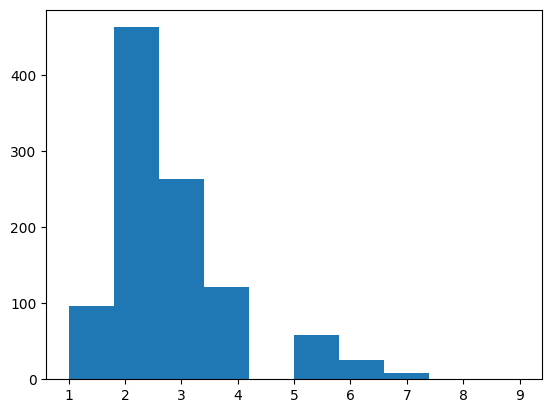

In [35]:
num_speakers = []
for thisid in train_df['Dialogue_ID'].unique():
    this_dialogue = train_df[train_df['Dialogue_ID'] == thisid]
    num_speakers.append(len(this_dialogue['Speaker'].unique()))

print(np.max(num_speakers))
plt.hist((num_speakers))
plt.show()

In [ ]:
# Here I redefine the custom model class and reload the trained weights
# We also extend the length of the tokenizer to accomodate the speaker tokens
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
special_speaker_tokens = [f"<speaker{i}>" for i in range(1, 10)]  # speaker1 to speaker9
tokenizer.add_special_tokens({'additional_special_tokens': special_speaker_tokens})
max_length = tokenizer.model_max_length
sep_token = tokenizer.sep_token

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 2 layers of the encoder
for layer in model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

class RobertaForEmotionClassification(nn.Module):
    def __init__(self, model, num_labels):
        super().__init__()
        self.roberta = model
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# Instantiate model
num_labels = 7  # e.g. 7 emotions
Full_model = RobertaForEmotionClassification(model, num_labels)

# Load the trained model for F1 score
model_path = "/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/best_emotion_model_5.pt"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

base_model = RobertaModel.from_pretrained("roberta-base")
Full_model = RobertaForEmotionClassification(base_model, num_labels)
Full_model.load_state_dict(checkpoint['model_state_dict'])
Full_model.roberta.resize_token_embeddings(len(tokenizer))


In [ ]:

def build_dynamic_context_inputs(df):
    inputs = []
    labels = []

    for dialog_id in df['Dialogue_ID'].unique():
        dialog = df[df['Dialogue_ID'] == dialog_id].sort_values('Utterance_ID')
        utterances = dialog['Utterance'].tolist()
        speakers = dialog['Speaker'].tolist()
        emotions = dialog['Emotion'].tolist()

        # Create speaker mapping for this dialogue
        unique_speakers = sorted(set(speakers))
        speaker_map = {name: f"<speaker{i+1}>" for i, name in enumerate(unique_speakers)}

        for idx in range(len(utterances)):
            context = []
            token_count = 0
            
            # Start from current utterance and go backward
            for i in range(idx, -1, -1):
                speaker_tag = speaker_map[speakers[i]]
                text_piece = f"{speaker_tag}: {utterances[i]}"
                tokens = tokenizer.tokenize(text_piece)
                token_count += len(tokens) + 1  # +1 for separator

                if token_count >= max_length:
                    break

                context.insert(0, text_piece)  # prepend so order is preserved

            input_text = f" {sep_token} ".join(context)
            inputs.append(input_text)
            labels.append(emotions[idx])

    return inputs, labels

train_inputs, train_labels = build_dynamic_context_inputs(train_df)
test_inputs, test_labels = build_dynamic_context_inputs(test_df)
dev_inputs, dev_labels = build_dynamic_context_inputs(dev_df)

In [ ]:
# Build new DataFrame from contextual inputs
label2id = {label: i for i, label in enumerate(sorted(set(train_labels)))} # Dict that maps each label to an integer
encoded_labels = [label2id[label] for label in train_labels]

# Now create the dataframe
data_dict = {
    "text": train_inputs,
    "label": encoded_labels
}
context_df = pd.DataFrame(data_dict)
train_dataset = Dataset.from_pandas(context_df)

# Function to tokenize the batch
def tokenize_batch(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512,
                     return_attention_mask=True)

# Apply tokenizer
train_tokenized = train_dataset.map(tokenize_batch, batched=True, batch_size=32)

# Prepare for PyTorch
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Sanity check
print(train_tokenized[0].keys())


# Now for the test set
test_label2id = {label: i for i, label in enumerate(sorted(set(test_labels)))} # Dict that maps each label to an integer
test_encoded_labels = [test_label2id[label] for label in test_labels]
test_data_dict = {
    "text": test_inputs,
    "label": test_encoded_labels
}
context_df = pd.DataFrame(test_data_dict)
test_dataset = Dataset.from_pandas(context_df)
test_tokenized = test_dataset.map(tokenize_batch, batched=True, batch_size=32)
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# dev set
dev_label2id = {label: i for i, label in enumerate(sorted(set(dev_labels)))} # Dict that maps each label to an integer
dev_encoded_labels = [dev_label2id[label] for label in dev_labels]
dev_data_dict = {
    "text": dev_inputs,
    "label": dev_encoded_labels
}
context_df = pd.DataFrame(dev_data_dict)
dev_dataset = Dataset.from_pandas(context_df)
dev_tokenized = dev_dataset.map(tokenize_batch, batched=True, batch_size=32)
dev_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# Create dataloaders for train and dev sets (and maybe also test set)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_tokenized, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_tokenized, batch_size=16)
test_loader = DataLoader(test_tokenized, batch_size=16)

In [ ]:
# Prepare for training

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Full_model.to(device)
optimizer = torch.optim.AdamW(Full_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

from transformers import get_linear_schedule_with_warmup

epochs = 15
total_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Store all metrics
all_train_batch_losses = []
all_val_batch_losses = []
all_train_batch_acc = []
all_val_batch_acc = []
epoch_train_accuracies = []
epoch_val_accuracies = []
epoch_train_losses = []
epoch_val_losses = []
all_learning_rates = []
best_val_loss = float('inf')

for epoch in range(epochs):
    Full_model.train()
    train_loss = 0
    correct = 0
    total = 0
    epoch_batch_losses = []
    epoch_batch_acc = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        all_learning_rates.append(current_lr)

        loss_value = loss.item()
        train_loss += loss_value
        epoch_batch_losses.append(loss_value)

        _, preds = torch.max(outputs, dim=1)
        batch_correct = (preds == labels).sum().item()
        correct += batch_correct
        total += labels.size(0)

        batch_acc = batch_correct / labels.size(0)
        epoch_batch_acc.append(batch_acc)

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total

    print(f"Epoch {epoch+1}: LR = {current_lr:.6f}")
    print(f"Train loss: {avg_loss:.4f} | Train accuracy: {accuracy:.4f}")

    all_train_batch_losses.extend(epoch_batch_losses)
    all_train_batch_acc.extend(epoch_batch_acc)
    epoch_train_losses.append(avg_loss)
    epoch_train_accuracies.append(accuracy)

    # Validation loop
    Full_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    val_epoch_losses = []
    val_epoch_acc = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_epoch_losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)
            batch_correct = (preds == labels).sum().item()
            correct += batch_correct
            total += labels.size(0)

            batch_acc = batch_correct / labels.size(0)
            val_epoch_acc.append(batch_acc)

    avg_val_loss = val_loss / len(dev_loader)
    val_accuracy = correct / total

    print(f"Val loss: {avg_val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")

    all_val_batch_losses.extend(val_epoch_losses)
    all_val_batch_acc.extend(val_epoch_acc)
    epoch_val_losses.append(avg_val_loss)
    epoch_val_accuracies.append(val_accuracy)

    # Save only if validation improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint_path = f"/kaggle/working/Extended_Token_model_{epoch+1}.pt"
        torch.save({
            'model_state_dict': Full_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'val_loss': avg_val_loss
        }, checkpoint_path)
        print(f"📈 New best model saved at {checkpoint_path}")

In [ ]:
print(len(all_train_batch_losses)),
print(len(all_val_batch_losses)),
print(len(all_train_batch_acc)),
print(len(all_val_batch_acc)),


In [ ]:
# Save training metrics
train_metrics_df = pd.DataFrame({
    'train_batch_loss': all_train_batch_losses,
    'train_batch_acc': all_train_batch_acc,
    'learning_rate': all_learning_rates
})
train_metrics_df.to_csv('/kaggle/working/train_batch_metrics.csv', index=False)

# Save validation metrics
val_metrics_df = pd.DataFrame({
    'val_batch_loss': all_val_batch_losses,
    'val_batch_acc': all_val_batch_acc
})
val_metrics_df.to_csv('/kaggle/working/val_batch_metrics.csv', index=False)

epoch_metrics_df = pd.DataFrame({
    'epoch_train_loss': epoch_train_losses,
    'epoch_val_loss': epoch_val_losses,
    'epoch_train_acc': epoch_train_accuracies,
    'epoch_val_acc': epoch_val_accuracies,
})

epoch_metrics_df.to_csv('/kaggle/working/epoch_metrics.csv', index=False)

In [ ]:

plt.plot(epoch_train_losses, label = 'Training loss')
plt.plot(epoch_val_losses, label = 'Validation loss')
plt.legend()
plt.show()


In [ ]:
checkpoint_path = f"/kaggle/working/Overfitted_Extended_Token_model.pt"
torch.save({
    'model_state_dict': Full_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': epoch,
    'val_loss': avg_val_loss
}, checkpoint_path)

In [ ]:
# ====== Evaluation on Test Set ======
Full_model.eval()
test_loss = 0
correct = 0
total = 0
test_batch_losses = []
test_batch_acc = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_batch_losses.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        batch_correct = (preds == labels).sum().item()
        correct += batch_correct
        total += labels.size(0)

        batch_acc = batch_correct / labels.size(0)
        test_batch_acc.append(batch_acc)

# Compute final test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"\n Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optionally, save test metrics
import pandas as pd

test_metrics_df = pd.DataFrame({
    'test_batch_loss': test_batch_losses,
    'test_batch_acc': test_batch_acc
})
test_metrics_df.to_csv('/kaggle/working/test_metrics.csv', index=False)
print("📁 Saved test metrics to /kaggle/working/test_metrics.csv")

2025-06-22 00:16:48.846917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750551409.046183      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750551409.101273      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0
Your max_length is set to 142, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


 'I had a long meeting about the new product and it went on forever. I had to go on forever,' he says . 'I'm not going to let it slide,' he adds. 'I was in the middle of the meeting. I'm going to be very happy with it,' he said .
